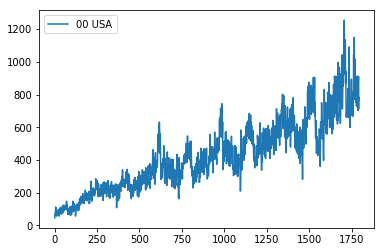

In [1]:
import pandas as pd
%matplotlib inline
df = pd.read_csv('./wifi/application.csv', usecols=[0,1], engine='python', skipfooter=0)
df.plot()

In [2]:
import numpy as np
import pandas as pd
import tflearn
import matplotlib.pyplot as plt
dataframe = pd.read_csv('./wifi/application.csv',
        usecols=[1],
        engine='python',
        skipfooter=0)
dataset = dataframe.values
dataset = dataset.astype('float32')

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
Scipy not supported!


In [3]:
dataset -= np.min(np.abs(dataset))
dataset /= np.max(np.abs(dataset))

In [4]:
def create_dataset(dataset, steps_of_history, steps_in_future):
    X, Y = [], []
    for i in range(0, len(dataset)-steps_of_history, steps_in_future):
        X.append(dataset[i:i+steps_of_history])
        Y.append(dataset[i + steps_of_history])
    X = np.reshape(np.array(X), [-1, steps_of_history, 1])
    Y = np.reshape(np.array(Y), [-1, 1])
    return X, Y

def split_data(x, y, test_size=0.1):
    pos = round(len(x) * (1 - test_size))
    trainX, trainY = x[:pos], y[:pos]
    testX, testY   = x[pos:], y[pos:]
    return trainX, trainY, testX, testY

steps_of_history = 1
steps_in_future = 1

X, Y = create_dataset(dataset, steps_of_history, steps_in_future)
trainX, trainY, testX, testY = split_data(X, Y, 0.1)

In [5]:
net = tflearn.input_data(shape=[None, steps_of_history, 1])
net = tflearn.lstm(net, n_units=6)
# net = tflearn.gru(net, n_units=6, return_seq=True)
# net = tflearn.gru(net, n_units=6)
net = tflearn.fully_connected(net, 1, activation='linear')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001, loss='mean_square')

model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(trainX, trainY, validation_set=0.1, batch_size=1, n_epoch=100)

Training Step: 145299  | total loss: 0.00303 | time: 5.199s
| Adam | epoch: 100 | loss: 0.00303 -- iter: 1452/1453
Training Step: 145300  | total loss: 0.00301 | time: 6.291s
| Adam | epoch: 100 | loss: 0.00301 | val_loss: 0.00144 -- iter: 1453/1453
--


In [6]:
testX2 = np.reshape(np.array(testX), [-1, 1, 1])

In [7]:
score = model.evaluate(testX2, testY)
score

[0.00558659217877095]

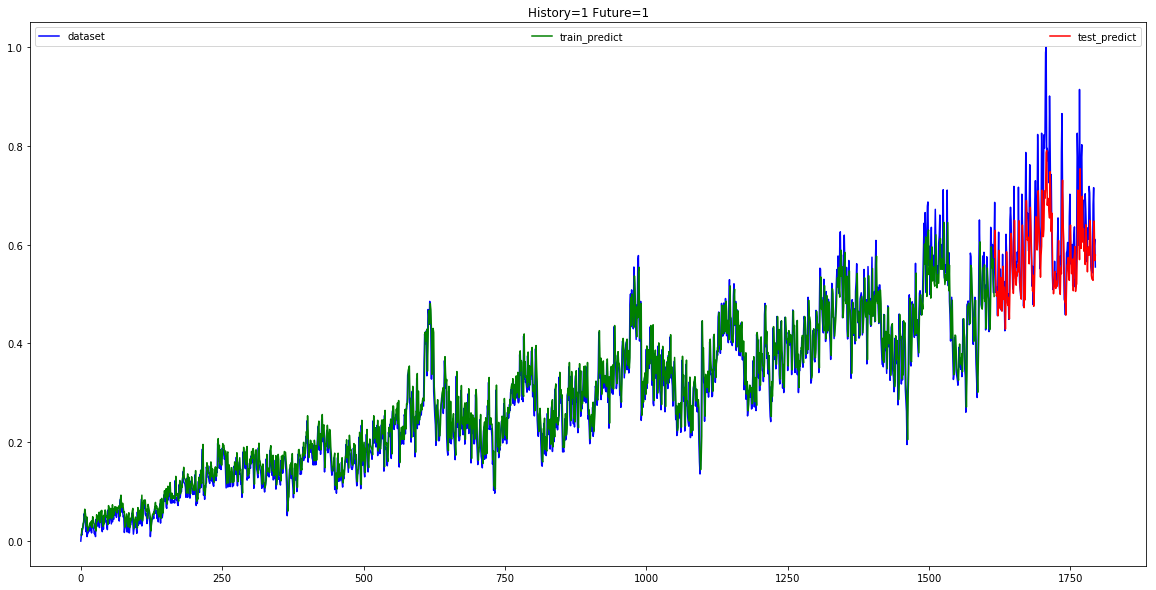

In [8]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[steps_of_history:len(train_predict)+steps_of_history, :] = train_predict

test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+steps_of_history:len(dataset), :] = test_predict

plt.figure(figsize=(20, 10))
plt.title('History={} Future={}'.format(steps_of_history, steps_in_future))
plt.plot(dataset, color='blue', label="dataset")
plt.plot(train_predict_plot, color='green', label="train_predict")
plt.plot(test_predict_plot, color='red', label="test_predict")
plt.legend(ncol=3, mode="expand")
plt.savefig('wifi.png')

In [9]:
train_predict

array([[0.01195617],
       [0.02504951],
       [0.02349951],
       ...,
       [0.5706677 ],
       [0.5191306 ],
       [0.49505323]], dtype=float32)

In [10]:
dataset

array([[0.        ],
       [0.01407285],
       [0.01241722],
       ...,
       [0.5960265 ],
       [0.61092716],
       [0.55463576]], dtype=float32)

In [11]:
# 平均二乗平方根誤差
def rmse(y_pred, y_true):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

def rmsle(y_pred, y_true):
    return np.sqrt(np.square(np.log(y_true + 1) - np.log(y_pred + 1)).mean())

# 平均絶対誤差
def mae(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred)))

# 平均絶対誤差率
def mape(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
trainX = np.reshape(np.array(trainX), [-1, 1])
testX = np.reshape(np.array(testX), [-1, 1])
delta = 1e-10

----
### 訓練データ

In [13]:
len(trainX)

1615

In [14]:
len(train_predict)

1615

In [15]:
rmse_train = rmse(train_predict, trainX)

In [16]:
mae_train = mae(train_predict, trainX)

In [17]:
mape_train = mape(train_predict[1:], trainX[1:])

----
### テストデータ

In [18]:
rmse_test = rmse(test_predict, testX)

In [19]:
mae_test = mae(test_predict, testX)

In [20]:
mape_test = mape(test_predict, testX)

----
##### テストデータ 直近のみ

In [21]:
test_predict_last05 = test_predict[1:7]
testX_last05 = testX[1:7]
test_predict_last10 = test_predict[1:10]
testX_last10 = testX[1:10]

In [22]:
rmse_test_last05 = rmse(test_predict_last05, testX_last05)
rmse_test_last10 = rmse(test_predict_last10, testX_last10)

In [23]:
mae_test_last05 = mae(test_predict_last05, testX_last05)
mae_test_last10 = mae(test_predict_last10, testX_last10)

In [24]:
mape_test_last05 = mape(test_predict_last05, testX_last05)
mape_test_last10 = mape(test_predict_last10, testX_last10)

----

In [25]:
print(rmse_train, rmse_test, rmse_test_last10, rmse_test_last05)
print(mae_train, mae_test, mae_test_last10, mae_test_last05)
print(mape_train, mape_test, mape_test_last10, mape_test_last05)

0.010630519 0.054115534 0.024506826 0.024724055
0.009214554 0.039906897 0.017770747 0.016388962
6.150134280323982 5.750631541013718 2.969531901180744 2.7092374861240387


In [26]:
for m in range(0, 3): # 3 months
    m_p = np.concatenate((test_predict[m*4*7:(m+1)*4*7]))
    m_t = np.concatenate((testX[m*4*7:(m+1)*4*7]))
    print('month-%02d' % (m+1), ':', mape(m_p, m_t))
for w in range(0, 3*4): # 3 months * 4 weeks
    w_p = np.concatenate((test_predict[w*7:(w+1)*7]))
    w_t = np.concatenate((testX[w*7:(w+1)*7]))
    print('week-%02d' % (w+1), ':', mape(w_p, w_t))
for d in range(3*4*7): # 3 months * 4 weeks * 7 days
    print('day-%02d' % (d+1), ':', mape(test_predict[d], testX[d])) 

month-01 : 2.2942109033465385
month-02 : 4.413691535592079
month-03 : 6.608913838863373
week-01 : 3.05106732994318
week-02 : 2.1374043077230453
week-03 : 1.8051635473966599
week-04 : 2.1832074970006943
week-05 : 4.779604449868202
week-06 : 4.459889605641365
week-07 : 3.8231436163187027
week-08 : 4.592127352952957
week-09 : 7.693742960691452
week-10 : 5.006883665919304
week-11 : 6.416329741477966
week-12 : 7.318697869777679
day-01 : 5.102045461535454
day-02 : 8.238032460212708
day-03 : 2.958524413406849
day-04 : 1.5054898336529732
day-05 : 1.64018664509058
day-06 : 1.8580332398414612
day-07 : 0.05515828961506486
day-08 : 3.397500514984131
day-09 : 5.859651416540146
day-10 : 1.2132104486227036
day-11 : 0.5454655736684799
day-12 : 3.103942610323429
day-13 : 0.4705890081822872
day-14 : 0.37146988324820995
day-15 : 1.8033172935247421
day-16 : 4.176827892661095
day-17 : 1.239543128758669
day-18 : 2.245930954813957
day-19 : 1.0042136535048485
day-20 : 0.7943728938698769
day-21 : 1.37193845584